In [2]:
"""
Written By: Rajeev Jain, jainraje@yahoo.com

Python code to implement concepts in Technical Analysis of S&C Magazine December 2025 article 
"The One Euro Filter" by John F Ehlers. This python code is provided for TraderTips section of 
the magazine.

"""

%matplotlib inline

In [3]:
# import required python libraries

import pandas as pd
import numpy as np
import yfinance as yf
import math
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpf

print(yf.__version__)

0.2.58


In [5]:
# three helper functions to 1) run one euro filter calculations 2) run oscillator calculations and
# to 3) plot the close vs one euro filter output on one subplot and the oscillator on a second subplot
# using built-in matplotlib capabilities.

def calc_one_euro_filter(close, period_min=10, beta=0.2):
    """
    One Euro Filter Indicator
    Adapted from Georges Casiez et al. (CHI 2012)
    Converted from EasyLanguage to Python 
    
    Args:
        close (array-like): List or NumPy array of closing prices
        period_min (float): Minimum cutoff period (default=10)
        beta (float): Responsiveness factor (default=0.2)
        
    Returns:
        np.ndarray: Smoothed signal
    """
    close = np.asarray(close)
    n = len(close)
    
    # Initialize arrays
    smoothed = np.zeros(n)
    smoothed_dx = np.zeros(n)
    
    period_dx = 10.0
    alpha_dx = 2 * np.pi / (4 * np.pi + period_dx)
    
    # Initialization
    smoothed[0] = close[0]
    smoothed_dx[0] = 0.0
    
    for i in range(1, n):
        # Delta smoothing (EMA of price change)
        smoothed_dx[i] = alpha_dx * (close[i] - close[i - 1]) + (1 - alpha_dx) * smoothed_dx[i - 1]
        
        # Adjust cutoff based on rate of change
        cutoff = period_min + beta * abs(smoothed_dx[i])
        
        # Compute adaptive alpha
        alpha3 = 2 * np.pi / (4 * np.pi + cutoff)
        
        # Adaptive smoothing
        smoothed[i] = alpha3 * close[i] + (1 - alpha3) * smoothed[i - 1]
    
    return smoothed


def calc_highpass(price, period):
    """
    Two-pole high-pass filter (John Ehlers style)
    
    Args:
        price (array-like): Sequence of prices
        period (float): Filter period
    
    Returns:
        np.ndarray: High-pass filtered values
    """
    price = np.asarray(price, dtype=float)
    n = len(price)
    out = np.zeros(n)

    # Filter coefficients
    a1 = np.exp(-1.414 * np.pi / period)
    b1 = 2 * a1 * np.cos(math.radians(1.414 * 180 / period))
    c2 = b1
    c3 = -a1 ** 2
    c1 = (1 + c2 - c3)/4

    # Main filter loop
    for i in range(2, n):
        out[i] = (
            c1 * (price[i] - 2 * price[i - 1] + price[i - 2])
            + c2 * out[i - 1]
            + c3 * out[i - 2]
        )

    # Initialize first values (pass-through)
    out[0:2] = price[0:2]

    return out


def plot_one_euro_filter(df):
    
    ax = df[['Close', 'OEF']].plot(grid=True, title=f"Ticker={symbol}, Close vs One Euro Filter", figsize=(9,4), marker='.')
    ax.set_xlabel('')

    ax = df[['Osc']].plot(grid=True, title=f"One Euro Filter Oscilator", figsize=(9,2))
    ax.set_xlabel('')



In [6]:
# Use Yahoo Finance python package to obtain OHLCV data for desired system set

symbol = '^GSPC'
start = "1990-01-01"
end = dt.datetime.now().strftime('%Y-%m-%d') 

ohlcv = yf.download(
    symbol, 
    start, 
    end,
    group_by="Ticker",  
    auto_adjust=False
)
ohlcv = ohlcv[symbol]
ohlcv

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000
1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000
1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000
1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000
1990-01-08,352.200012,354.239990,350.540009,353.790009,353.790009,140110000
...,...,...,...,...,...,...
2025-10-13,6622.529785,6668.680176,6620.709961,6654.720215,6654.720215,5303960000
2025-10-14,6602.490234,6680.700195,6555.069824,6644.310059,6644.310059,5666920000
2025-10-15,6688.270020,6724.120117,6612.109863,6671.060059,6671.060059,5633060000


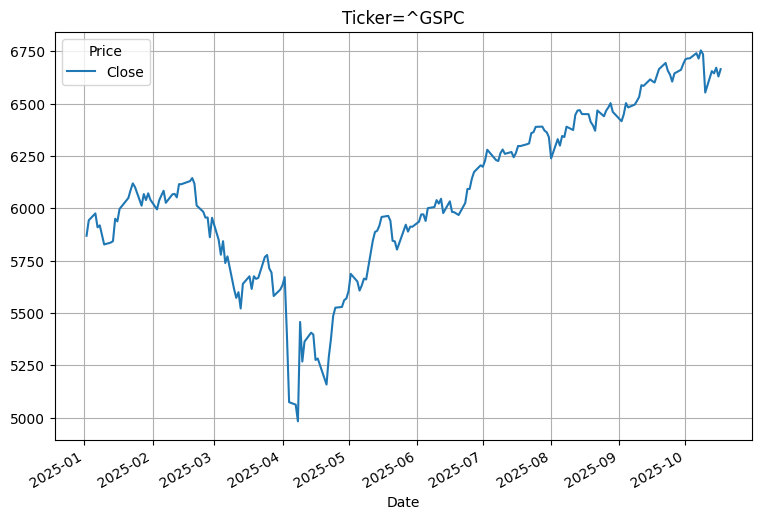

In [7]:
df = ohlcv.copy()
ax = df[['Close']]['2025':].plot(grid=True, title=f"Ticker={symbol}", figsize=(9,6))

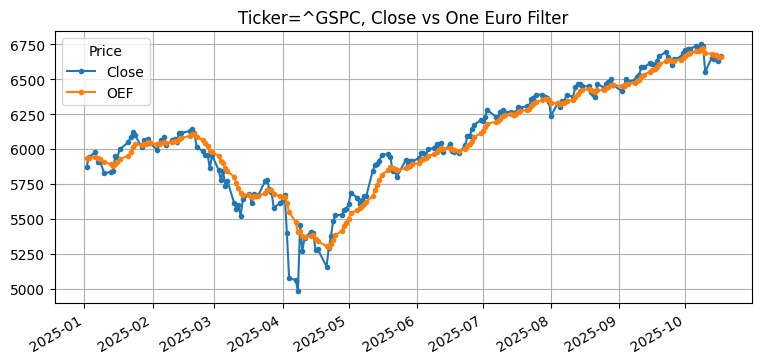

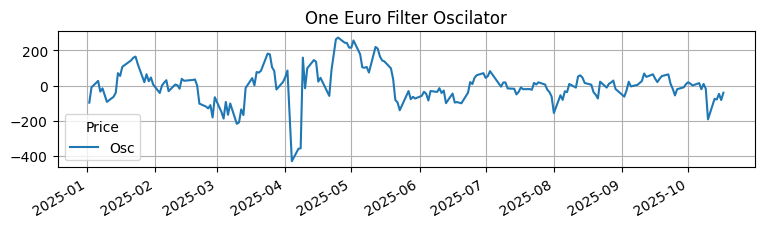

In [8]:
# call helper functions to calculate the One Euro Filter output (named OEF) and the 
# Oscillaor output (named Osc) and then plot close, OEF and Ocs values.

df['OEF'] = calc_one_euro_filter(df['Close'], period_min=10, beta=0.2)
df['Osc'] = calc_highpass(df['Close'], period=54)
plot_one_euro_filter(df['2025':])